In [2]:
import numpy as np 
import pandas as pd 
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import os

In [4]:
import warnings
warnings.filterwarnings('ignore')
import PIL
import numpy as np
import random
from tensorflow import keras
from tensorflow.keras import preprocessing
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout,Flatten,Activation
from keras.utils import plot_model
from sklearn.preprocessing import OneHotEncoder
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization
from keras.models import load_model
import cv2
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Input
from tensorflow.keras.optimizers import Adam
import shutil
import glob
import random

In [5]:
os.chdir("/kaggle/working/")

In [6]:
path = (r'/kaggle/input/brain-tumor-classification-mri/Training/')
glioma_dir= os.path.join(path,'glioma_tumor')
meningioma_dir= os.path.join(path,'meningioma_tumor')
pituitary_dir= os.path.join(path,'pituitary_tumor')
no_tumor_dir=os.path.join(path,'no_tumor')

In [7]:
dir = [glioma_dir, meningioma_dir, pituitary_dir,no_tumor_dir]
classification = ['glioma', 'meningioma', 'pituitary','no_tumor']
length=[]
for name, dir in zip(classification, dir):
    num_of_images = len(os.listdir(dir))
    print(f'Number of {name} images: {num_of_images}')
    length.append(len(os.listdir(dir)))

Number of glioma images: 826
Number of meningioma images: 822
Number of pituitary images: 827
Number of no_tumor images: 395


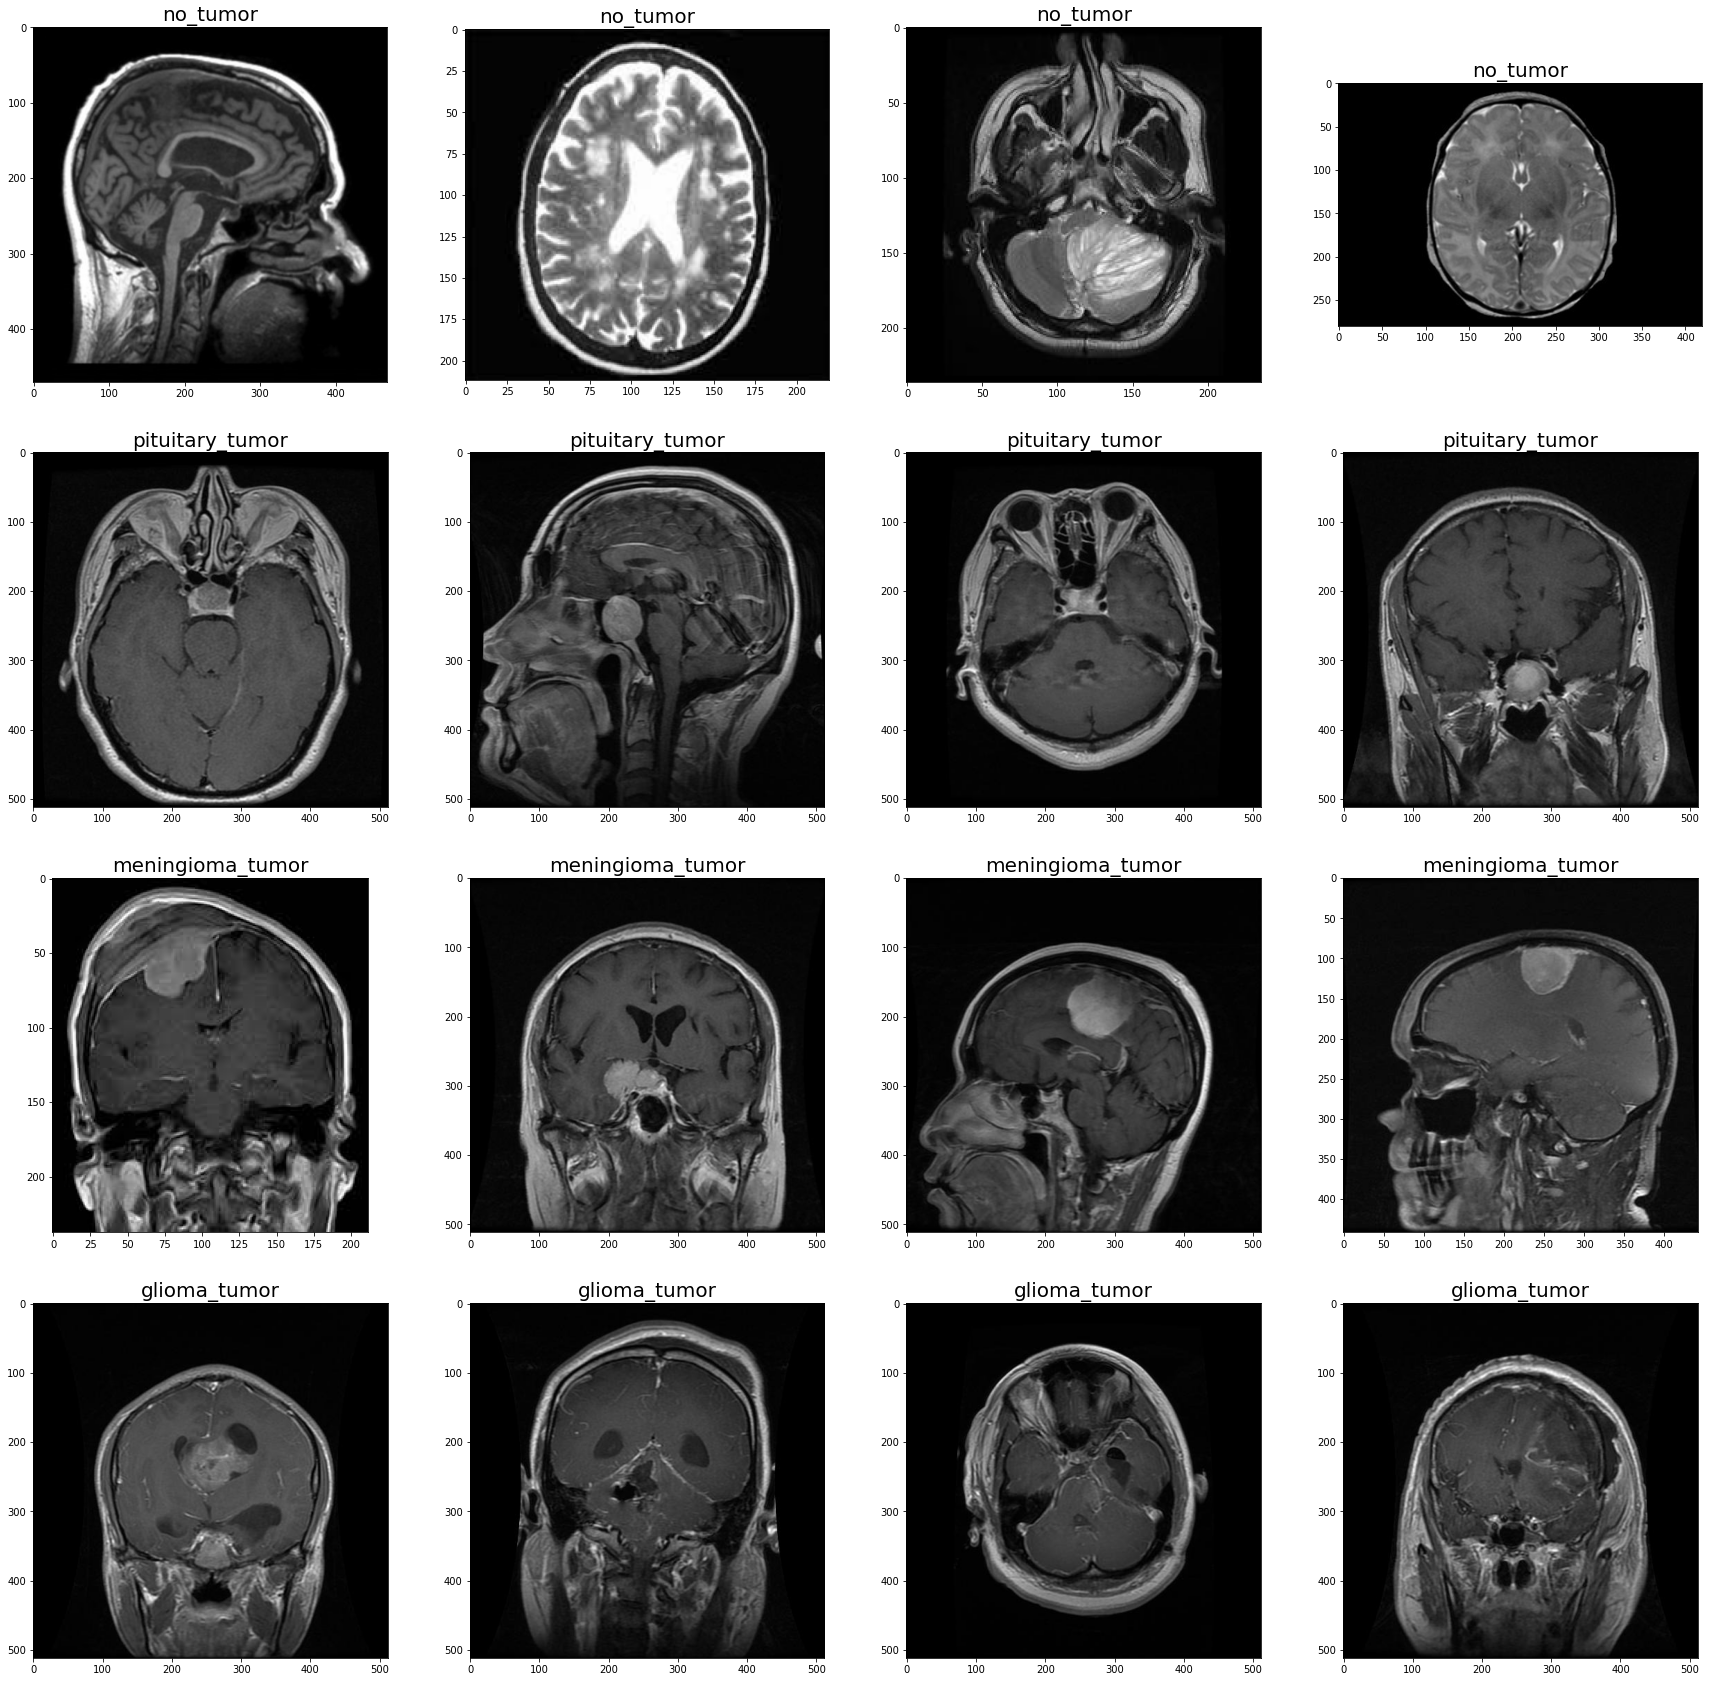

In [8]:
plt.figure(figsize=(30,30))
l= [os.path.join(path,f) for f in os.listdir(path)]
ind=0
for d in range(0,4):
    for i in range(0,4):
        ind+=1
        file = random.choice(os.listdir(l[d]))
        image_path= os.path.join(l[d], file)
        img=Image.open(image_path)
        plt.subplot(4,4,ind)
        plt.title((os.listdir(path)[d]), fontsize=20)
        plt.imshow(img)

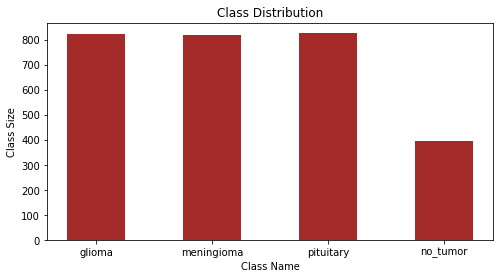

In [9]:
dir = [glioma_dir, meningioma_dir, pituitary_dir,no_tumor_dir]
fig,ax = plt.subplots(figsize=(8,4))
image_length=[]
for d in dir:
    image_length.append(len(os.listdir(d))) 
ax.bar(classification,image_length, width=0.50, color='brown')
ax.set(title="Class Distribution", xlabel="Class Name", ylabel="Class Size")
plt.show()

In [10]:
image_size= 150
X=[]
y=[]
for folder in os.listdir(path):
    for subfolder in os.listdir(os.path.join(path,folder)):
        y.append(folder)
        img = cv2.imread(os.path.join(path,folder,subfolder), cv2.IMREAD_GRAYSCALE)
        im = cv2.resize(img,(image_size,image_size))
        im.reshape(-1,image_size,image_size)
        X.append(im) 

In [11]:
X_arr=np.array(X).reshape(-1,image_size,image_size)
y_arr=np.array(y)
X_arr=X_arr/255.
X= X_arr.reshape(-1,image_size,image_size,1)
enc=LabelEncoder()
y = enc.fit_transform(y_arr)
y=to_categorical(y,4)

In [12]:
X_train , X_test, y_train, y_test = train_test_split(X , y , test_size = 0.1, random_state = 42)
X_train , X_val, y_train, y_val = train_test_split(X_train , y_train , test_size = 0.1, random_state = 42)
print(len(X_train)+len(X_val)+len(X_test))

2870


In [13]:
print(X_train.shape)
print(y_train.shape)

(2324, 150, 150, 1)
(2324, 4)


# **1st Model: The Base CNN Model without Data Augmentation**

In [14]:
def create_model(units=512, learning_rate=0.001):
    model =Sequential()
    model.add(Input(shape=(150,150,1)))
    
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

# Adding a third convolutional layer
    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

# Adding a fourth convolutional layer
    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    
    
    model.add(Conv2D(filters= 128, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    
    model.add(Conv2D(filters= 128, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

                        
    model.add(Flatten())
    model.add(Dense(units=units, activation='relu'))
    
    model.add(Dense(units=4, activation='softmax'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

model1= create_model(units=512, learning_rate=0.001)
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [15]:
callbacks1=[ EarlyStopping(monitor='val_accuracy', patience=3,mode="auto",verbose=0,restore_best_weights=True),
            ModelCheckpoint(filepath='best_accuracy_model1.hdf5', monitor='val_accuracy', verbose=0,mode='max',save_best_only=True)]

history1= model1.fit(X_train,y_train,batch_size=40, callbacks=callbacks1,epochs = 20, validation_data=(X_val,y_val))

Epoch 1/20
59/59 [==============================] - 123s 2s/step - loss: 1.2897 - accuracy: 0.3490 - val_loss: 1.1774 - val_accuracy: 0.5174
Epoch 2/20
59/59 [==============================] - 123s 2s/step - loss: 0.9314 - accuracy: 0.5924 - val_loss: 0.8057 - val_accuracy: 0.6680
Epoch 3/20
59/59 [==============================] - 122s 2s/step - loss: 0.6813 - accuracy: 0.7192 - val_loss: 0.7845 - val_accuracy: 0.6950
Epoch 4/20
59/59 [==============================] - 121s 2s/step - loss: 0.5514 - accuracy: 0.7832 - val_loss: 0.5422 - val_accuracy: 0.7876
Epoch 5/20
59/59 [==============================] - 122s 2s/step - loss: 0.3988 - accuracy: 0.8381 - val_loss: 0.4959 - val_accuracy: 0.7915
Epoch 6/20
59/59 [==============================] - 123s 2s/step - loss: 0.3334 - accuracy: 0.8686 - val_loss: 0.4758 - val_accuracy: 0.8533
Epoch 7/20
59/59 [==============================] - 123s 2s/step - loss: 0.2319 - accuracy: 0.9072 - val_loss: 0.9201 - val_accuracy: 0.7529
Epoch 8/20
59

In [16]:
test_loss, test_acc = model1.evaluate(X_test,y_test)

9/9 [==============================] - 4s 464ms/step - loss: 0.2844 - accuracy: 0.9268


In [17]:
def plot(hist='history_num'):
    
    train_loss = hist.history['loss']
    val_loss =hist.history['val_loss']

    eff_epochs = len(hist.history['loss'])
    epochs_range = range(eff_epochs)

    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xticks(epochs_range)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('Loss')
    plt.legend()

    train_acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')

    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.xticks(epochs_range)
    plt.title('Accuracy')
    plt.legend()
    plt.show()

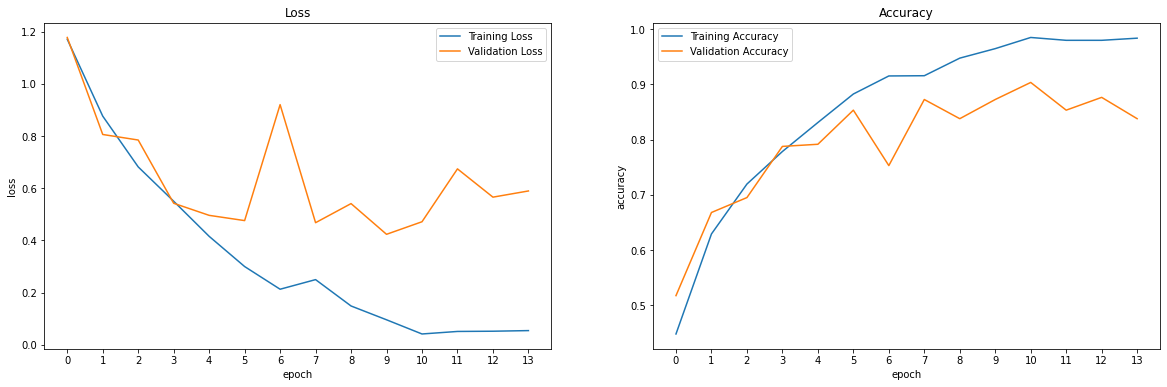

In [18]:
plot(history1)

In [19]:
model1.save_weights('model1_weights.h5')
model1.save('model1.h5')

# **2nd Model: The Base CNN Model with Padding and Dropout without Data Augmentation**

In [20]:
def create_model(units=512, learning_rate=0.001):
    model =Sequential()
    model.add(Input(shape=(150,150,1)))
    
    model.add(Conv2D(filters=64, kernel_size=(3,3),padding='same', activation='relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same', strides=2))

# Adding a third convolutional layer
    model.add(Conv2D(filters=128, kernel_size=(3,3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same', strides=2))

# Adding a fourth convolutional layer
    model.add(Conv2D(filters=128, kernel_size=(3,3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same', strides=2))
    
    
    model.add(Conv2D(filters= 128, kernel_size=(3,3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same', strides=2))
    
    model.add(Conv2D(filters= 128, kernel_size=(3,3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same', strides=2))

                        
    model.add(Flatten())
    model.add(Dense(units=units, activation='relu'))
    
    model.add(Dense(units=4, activation='softmax'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

model2= create_model(units=512, learning_rate=0.001)
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 150, 150, 64)      640       
_________________________________________________________________
dropout (Dropout)            (None, 150, 150, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 38, 38, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 38, 38, 128)       147584    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 19, 19, 128)      

In [21]:
callbacks2=[ EarlyStopping(monitor='val_accuracy', patience=3,mode="auto",verbose=0,restore_best_weights=True),
            ModelCheckpoint(filepath='best_accuracy_model2.hdf5', monitor='val_accuracy', verbose=0,mode='max',save_best_only=True)]

history2= model2.fit(X_train,y_train,batch_size=40, callbacks=callbacks2, epochs = 20, validation_data=(X_val,y_val))

Epoch 1/20
59/59 [==============================] - 182s 3s/step - loss: 1.2051 - accuracy: 0.4487 - val_loss: 0.9595 - val_accuracy: 0.5676
Epoch 2/20
59/59 [==============================] - 165s 3s/step - loss: 0.7928 - accuracy: 0.6488 - val_loss: 0.6480 - val_accuracy: 0.7027
Epoch 3/20
59/59 [==============================] - 164s 3s/step - loss: 0.6536 - accuracy: 0.7135 - val_loss: 0.8277 - val_accuracy: 0.6371
Epoch 4/20
59/59 [==============================] - 179s 3s/step - loss: 0.4714 - accuracy: 0.7979 - val_loss: 0.5071 - val_accuracy: 0.7954
Epoch 5/20
59/59 [==============================] - 165s 3s/step - loss: 0.4642 - accuracy: 0.8049 - val_loss: 0.5416 - val_accuracy: 0.7297
Epoch 6/20
59/59 [==============================] - 165s 3s/step - loss: 0.2683 - accuracy: 0.8969 - val_loss: 0.3228 - val_accuracy: 0.8803
Epoch 7/20
59/59 [==============================] - 164s 3s/step - loss: 0.1686 - accuracy: 0.9405 - val_loss: 0.6123 - val_accuracy: 0.7722
Epoch 8/20
59

In [22]:
test_loss, test_acc = model2.evaluate(X_test,y_test)

9/9 [==============================] - 5s 532ms/step - loss: 0.2510 - accuracy: 0.8885


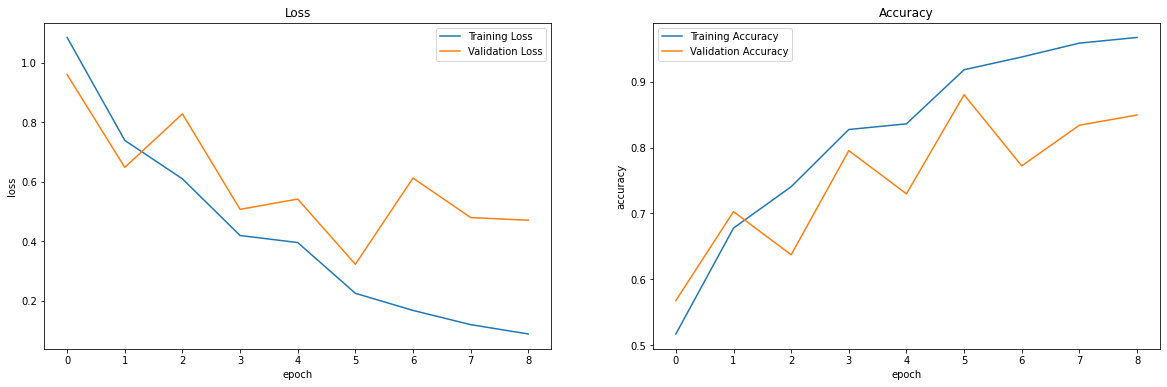

In [23]:
plot(history2)

In [24]:
model2.save_weights('model2_weights.h5')
model2.save('model2.h5')

# **3rd Model: The Base CNN Model with Padding and Dropout and with Data Augmentation**

In [14]:
data_augmentation = ImageDataGenerator(shear_range = 0.1,
                                       zoom_range = 0.2, 
                                       width_shift_range=0.10,
                                       height_shift_range=0.10,
                                       horizontal_flip = True,
                                       rotation_range=20,
                                       fill_mode='nearest')
data_augmentation.fit(X_train)

In [15]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Input
from tensorflow.keras.optimizers import Adam
def create_model(units=512, learning_rate=0.001):
    model =Sequential()
    model.add(Input(shape=(150,150,1)))
    
    model.add(Conv2D(filters=64, kernel_size=(3,3),padding='same', activation='relu'))
    model.add(Dropout(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same', strides=2))

# Adding a third convolutional layer
    model.add(Conv2D(filters=128, kernel_size=(3,3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same', strides=2))

# Adding a fourth convolutional layer
    model.add(Conv2D(filters=128, kernel_size=(3,3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same', strides=2))
    
    
    model.add(Conv2D(filters= 128, kernel_size=(3,3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same', strides=2))
    
    model.add(Conv2D(filters= 128, kernel_size=(3,3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same', strides=2))

                        
    model.add(Flatten())
    model.add(Dense(units=units, activation='relu'))
    
    
    model.add(Dense(units=4, activation='softmax'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

model3= create_model(units=512, learning_rate=0.001)
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 64)      640       
_________________________________________________________________
dropout (Dropout)            (None, 150, 150, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 38, 38, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 19, 19, 128)       0

In [16]:
callbacks3=[ EarlyStopping(monitor='val_accuracy', patience=3,mode="auto",verbose=0,restore_best_weights=True),
            ModelCheckpoint(filepath='best_accuracy_model32.hdf5', monitor='val_accuracy', verbose=0,mode='max',save_best_only=True)]

history3= model3.fit_generator(data_augmentation.flow(X_train,y_train,batch_size=40), callbacks=callbacks3,
                    epochs = 20, validation_data=(X_val,y_val))

Epoch 1/20
59/59 [==============================] - 142s 2s/step - loss: 1.3122 - accuracy: 0.3333 - val_loss: 1.1237 - val_accuracy: 0.5637
Epoch 2/20
59/59 [==============================] - 140s 2s/step - loss: 1.1322 - accuracy: 0.5135 - val_loss: 0.9817 - val_accuracy: 0.5367
Epoch 3/20
59/59 [==============================] - 140s 2s/step - loss: 0.9722 - accuracy: 0.5614 - val_loss: 0.9104 - val_accuracy: 0.5714
Epoch 4/20
59/59 [==============================] - 140s 2s/step - loss: 0.9164 - accuracy: 0.5820 - val_loss: 0.8659 - val_accuracy: 0.5676
Epoch 5/20
59/59 [==============================] - 140s 2s/step - loss: 0.8280 - accuracy: 0.6271 - val_loss: 1.0057 - val_accuracy: 0.5367
Epoch 6/20
59/59 [==============================] - 139s 2s/step - loss: 0.7830 - accuracy: 0.6666 - val_loss: 0.7163 - val_accuracy: 0.6950
Epoch 7/20
59/59 [==============================] - 141s 2s/step - loss: 0.7305 - accuracy: 0.6892 - val_loss: 0.6116 - val_accuracy: 0.7181
Epoch 8/20
59

In [17]:
test_loss, test_acc = model3.evaluate(X_test,y_test)

9/9 [==============================] - 4s 402ms/step - loss: 0.3129 - accuracy: 0.9059


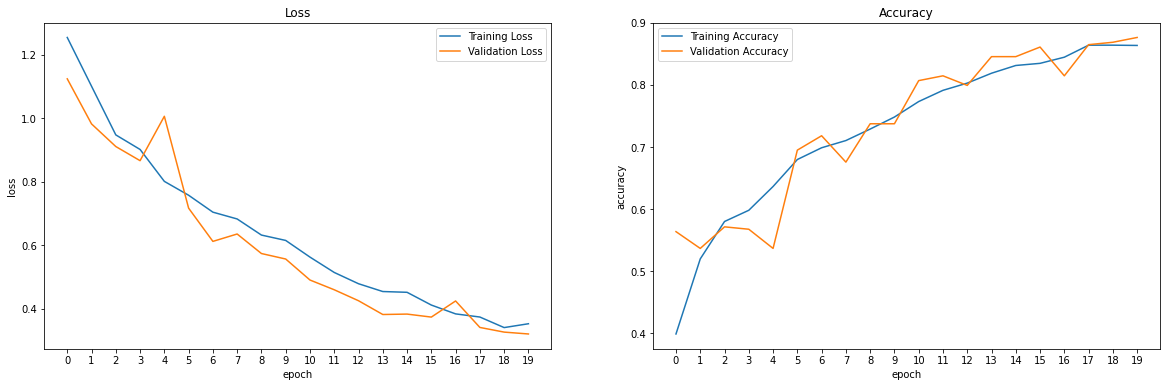

In [18]:
plot(history3)

In [ ]:
model3.save_weights('model3_weights.h5')
model3.save('model3.h5')

# **4th Model: The Base CNN Model with Padding and Data Augmentation No Dropout**

In [23]:
def create_model(units=512, learning_rate=0.001):
    model =Sequential()
    model.add(Input(shape=(150,150,1)))
    
    model.add(Conv2D(filters=64, kernel_size=(3,3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same', strides=2))


    model.add(Conv2D(filters=128, kernel_size=(3,3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same', strides=2))

    model.add(Conv2D(filters=128, kernel_size=(3,3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same', strides=2))
    
    
    model.add(Conv2D(filters= 128, kernel_size=(3,3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same', strides=2))
    
    model.add(Conv2D(filters= 128, kernel_size=(3,3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same', strides=2))

                        
    model.add(Flatten())
    model.add(Dense(units=units, activation='relu'))
    
    model.add(Dense(units=4, activation='softmax'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

model6= create_model(units=512, learning_rate=0.001)
model6.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 150, 150, 64)      640       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 75, 75, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 38, 38, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 38, 38, 128)       147584    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 19, 19, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 19, 19, 128)      

In [24]:
callbacks6=[ EarlyStopping(monitor='val_accuracy', patience=3,mode="auto",verbose=0,restore_best_weights=True),
            ModelCheckpoint(filepath='best_accuracy_model61.hdf5', monitor='val_accuracy', verbose=0,mode='max',save_best_only=True)]

history6= model6.fit_generator(data_augmentation.flow(X_train,y_train,batch_size=40), callbacks=callbacks6,
                    epochs = 20, validation_data=(X_val,y_val))

Epoch 1/20
59/59 [==============================] - 119s 2s/step - loss: 1.3320 - accuracy: 0.3337 - val_loss: 1.1112 - val_accuracy: 0.4517
Epoch 2/20
59/59 [==============================] - 118s 2s/step - loss: 1.0877 - accuracy: 0.5032 - val_loss: 1.0212 - val_accuracy: 0.5753
Epoch 3/20
59/59 [==============================] - 118s 2s/step - loss: 0.9722 - accuracy: 0.5700 - val_loss: 0.8871 - val_accuracy: 0.6100
Epoch 4/20
59/59 [==============================] - 117s 2s/step - loss: 0.8949 - accuracy: 0.6036 - val_loss: 0.9654 - val_accuracy: 0.6062
Epoch 5/20
59/59 [==============================] - 118s 2s/step - loss: 0.8692 - accuracy: 0.6282 - val_loss: 0.8148 - val_accuracy: 0.6255
Epoch 6/20
59/59 [==============================] - 117s 2s/step - loss: 0.7860 - accuracy: 0.6680 - val_loss: 0.7831 - val_accuracy: 0.6409
Epoch 7/20
59/59 [==============================] - 118s 2s/step - loss: 0.7760 - accuracy: 0.6598 - val_loss: 0.7637 - val_accuracy: 0.6255
Epoch 8/20
59

In [25]:
test_loss, test_acc = model6.evaluate(X_test,y_test)

9/9 [==============================] - 4s 406ms/step - loss: 0.3155 - accuracy: 0.8815


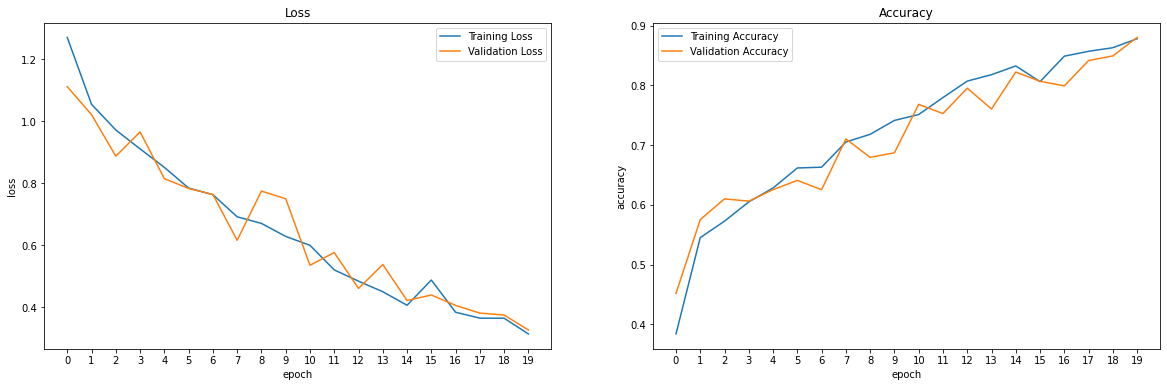

In [26]:
plot(history6)

In [27]:
model6.save_weights('model6_weights.h5')
model6.save('model6.h5')

# TRANSFER LEARNING

## **5th Model:  VGG16**

In [25]:
from keras.applications.vgg16 import VGG16

In [26]:
image_size= 150
X=[]
y=[]
for folder in os.listdir(path):
    for subfolder in os.listdir(os.path.join(path,folder)):
        y.append(folder)
        img = cv2.imread(os.path.join(path,folder,subfolder))
        im = cv2.resize(img,(image_size,image_size))
        X.append(im) 

In [27]:
X_arr=np.array(X).reshape(-1,image_size,image_size)
y_arr=np.array(y)
X_arr=X_arr/255.
X= X_arr.reshape(-1,image_size,image_size,3)
enc=LabelEncoder()
y = enc.fit_transform(y_arr)
y=to_categorical(y,4)

In [28]:
X_train , X_test, y_train, y_test = train_test_split(X , y , test_size = 0.1, random_state = 42)
X_train , X_val, y_train, y_val = train_test_split(X_train , y_train , test_size = 0.1, random_state = 42)
print(len(X_train)+len(X_val)+len(X_test))
print(X_train.shape, y_train.shape)

2870
(2324, 150, 150, 3) (2324, 4)


In [29]:
data_augmentation = ImageDataGenerator(shear_range = 0.1,
                                       zoom_range = 0.2, 
                                       width_shift_range=0.10,
                                       height_shift_range=0.10,
                                       horizontal_flip = True,
                                       rotation_range=20,
                                       fill_mode='nearest')
data_augmentation.fit(X_train)

In [30]:
vgg16_model= VGG16(weights="imagenet",include_top=False,input_shape=(150,150,3))

58892288/58889256 [==============================] - 1s 0us/step


In [31]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [32]:
for layer in vgg16_model.layers:
    layer.trainable=False

In [33]:
model_vgg=Sequential()
model_vgg.add(vgg16_model)
model_vgg.add(Flatten())
model_vgg.add(Dense(units=512, activation='relu'))    
model_vgg.add(Dense(units=4, activation='softmax'))
model_vgg.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 2052      
Total params: 18,911,556
Trainable params: 4,196,868
Non-trainable params: 14,714,688
_________________________________________________________________


In [35]:
type(model_vgg)

tensorflow.python.keras.engine.sequential.Sequential

In [36]:
model_vgg.compile(optimizer = Adam(lr=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [37]:
callbacks_vgg=[ EarlyStopping(monitor='val_accuracy', patience=3,mode="auto",verbose=0,restore_best_weights=True),
            ModelCheckpoint(filepath='best_accuracy_vgg.hdf5', monitor='val_accuracy', verbose=0, mode='max',save_best_only=True)]

historyvgg= model_vgg.fit_generator(data_augmentation.flow(X_train,y_train,batch_size=40), callbacks=callbacks_vgg,
                    epochs = 20, validation_data=(X_val,y_val))

Epoch 1/20
59/59 [==============================] - 314s 5s/step - loss: 1.7435 - accuracy: 0.5378 - val_loss: 0.6315 - val_accuracy: 0.7027
Epoch 2/20
59/59 [==============================] - 304s 5s/step - loss: 0.6024 - accuracy: 0.7543 - val_loss: 0.6516 - val_accuracy: 0.7259
Epoch 3/20
59/59 [==============================] - 304s 5s/step - loss: 0.5302 - accuracy: 0.7953 - val_loss: 0.4207 - val_accuracy: 0.8224
Epoch 4/20
59/59 [==============================] - 315s 5s/step - loss: 0.5304 - accuracy: 0.8011 - val_loss: 0.3761 - val_accuracy: 0.8649
Epoch 5/20
59/59 [==============================] - 305s 5s/step - loss: 0.4416 - accuracy: 0.8235 - val_loss: 0.5159 - val_accuracy: 0.8185
Epoch 6/20
59/59 [==============================] - 310s 5s/step - loss: 0.4026 - accuracy: 0.8347 - val_loss: 0.4124 - val_accuracy: 0.8571
Epoch 7/20
59/59 [==============================] - 304s 5s/step - loss: 0.3823 - accuracy: 0.8534 - val_loss: 0.5398 - val_accuracy: 0.8185


In [38]:
test_loss, test_acc = model_vgg.evaluate(X_test,y_test)

9/9 [==============================] - 39s 4s/step - loss: 0.3294 - accuracy: 0.8711


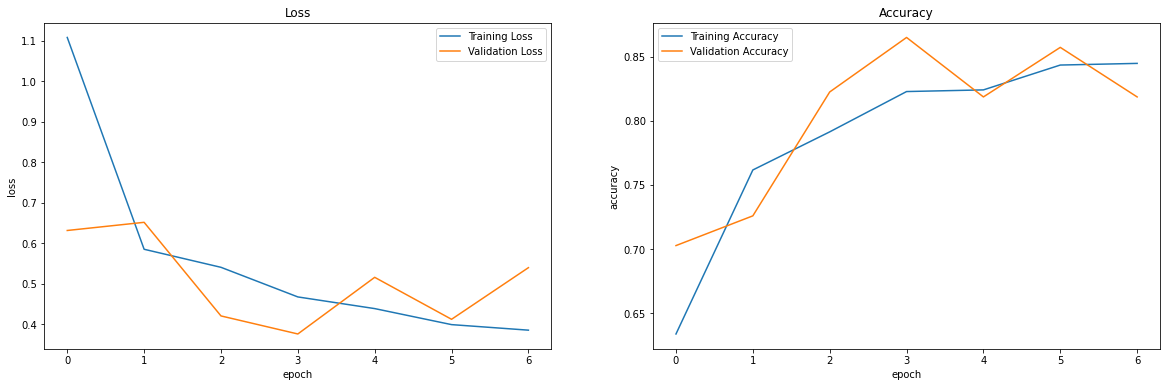

In [39]:
plot(historyvgg)

In [41]:
model_vgg.save('model_vgg.h5')
model_vgg.save_weights('model_vgg16_weights.h5')

## **6 th Model: RESNET50**

In [42]:
from tensorflow.keras.applications import ResNet50

In [43]:
resnet_model = ResNet50(input_shape=(150, 150,3), include_top=False, weights="imagenet")

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
for layer in resnet_model.layers:
    layer.trainable = False

In [44]:
resnet=Sequential()
resnet.add(resnet_model)
resnet.add(Flatten())
resnet.add(Dense(units=512, activation='relu'))    
resnet.add(Dense(units=4, activation='softmax'))
resnet.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               26214912  
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 2052      
Total params: 49,804,676
Trainable params: 49,751,556
Non-trainable params: 53,120
_________________________________________________________________


In [45]:
resnet.compile(optimizer = Adam(lr=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
callbacks_resnet=[ EarlyStopping(monitor='val_accuracy', patience=3,mode="auto",verbose=0,restore_best_weights=True),
            ModelCheckpoint(filepath='best_accuracy_resnet.hdf5', monitor='val_accuracy', verbose=0, mode='max',save_best_only=True)]

history_resnet= resnet.fit_generator(data_augmentation.flow(X_train,y_train,batch_size=40), callbacks=callbacks_resnet,
                    epochs = 20, validation_data=(X_val,y_val))

Epoch 1/20
59/59 [==============================] - 523s 9s/step - loss: 10.5025 - accuracy: 0.5138 - val_loss: 51.3017 - val_accuracy: 0.1120
Epoch 2/20
59/59 [==============================] - 522s 9s/step - loss: 0.5831 - accuracy: 0.7731 - val_loss: 64.9753 - val_accuracy: 0.1120
Epoch 3/20
59/59 [==============================] - 527s 9s/step - loss: 0.4440 - accuracy: 0.8499 - val_loss: 12.2299 - val_accuracy: 0.1120
Epoch 4/20
59/59 [==============================] - 513s 9s/step - loss: 0.3808 - accuracy: 0.8752 - val_loss: 6.2450 - val_accuracy: 0.1120


In [46]:
test_loss, test_acc = resnet.evaluate(X_test,y_test)

9/9 [==============================] - 11s 1s/step - loss: 57.1741 - accuracy: 0.1150


In [47]:
type(resnet)

tensorflow.python.keras.engine.sequential.Sequential

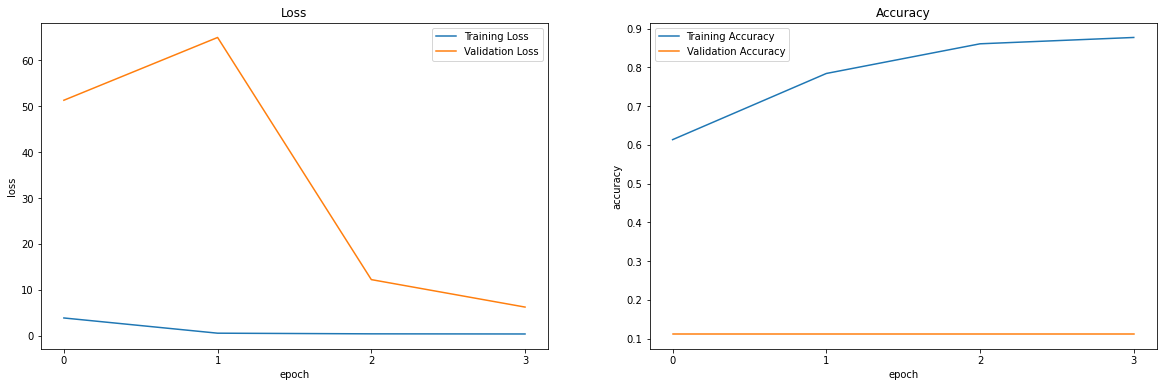

In [48]:
plot(history_resnet)

In [49]:
resnet.save('model_resnet.h5')
resnet.save_weights('model_resnet_weights.h5')